In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as Keras_backend
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import math
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.datasets import make_moons
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam, SGD

In [ ]:
sns.set()
random_seed= 42

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [ ]:
def make_training_data():
  (moons_xy, moons_labels) = make_moons(n_samples=8*256, noise=.08)
  X_train, X_test, y_train, y_test = \
    train_test_split(moons_xy, moons_labels, test_size=0.25)
  scaler = StandardScaler()
  scaler.fit(X_train)
  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)
  return (X_train, X_test, y_train, y_test)

In [43]:
def plot_training_data(X_train, y_train):
  plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='rainbow')
  plt.title('Two moons training data')
  plt.savefig('plot-weights-training-data')
  plt.show()

In [68]:
def make_binary_model(layer_sizes, eta):
    np.random.seed(random_seed)
    layer_list = []
    for i in range(len(layer_sizes)):
        kwargs = {'units': layer_sizes[i], 'kernel_initializer': 'normal'}
        if i==0:
            kwargs['input_shape'] = [2]
        if i==len(layer_sizes)-1:
            kwargs['activation'] = 'sigmoid'
        else:
            kwargs['activation'] = 'relu'
        new_layer = Dense(**kwargs)
        layer_list.append(new_layer)
        print("i=",i," kwargs=",kwargs)

    model = Sequential()
    for i in range(len(layer_sizes)):
        model.add(layer_list[i])  

    sgd = SGD(lr=eta)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return (layer_list, model)

In [59]:
def build_and_run_model(num_epochs, layer_sizes, eta):
    np.random.seed(random_seed)

    (layer_list, model) = make_binary_model(layer_sizes, eta)
    model.summary()

    history_list = []
    weight_history = []
    for i in range(num_epochs):
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                  epochs=1, batch_size=1, verbose=0) 
        history_list.append(history)
        weight_row = []
        for layer in layer_list:
            lgw = layer.get_weights()
            layer_weights =  [v for v in np.ravel(lgw[0])] 
            layer_weights += [v for v in lgw[1]]
            weight_row.append(layer_weights)
        weight_history.append(weight_row)
    weight_history = np.array(weight_history)
    return (model, layer_list, weight_history, history_list)

In [61]:
def plot_decision_boundary(X, y, eta, pred_func):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
  
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='rainbow')
    title = 'Decision boundaries for learning rate = {:.04f}'.format(eta)
    plt.title(title)
    
    filename = 'plot-weights-decision-boundaries-eta-{:.04f}'.format(eta)
    plt.savefig(filename)
    plt.show()

In [63]:
def show_history_graphs(history_list, eta):
    
    acc_list = [h.history['acc'] for h in history_list]
    loss_list = [h.history['loss'] for h in history_list]
    val_acc_list = [h.history['val_acc'] for h in history_list]
    val_loss_list = [h.history['val_loss'] for h in history_list]
    plt.figure(figsize=(10,4))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(acc_list)), acc_list, label='train accuracy', color='red')
    plt.plot(range(len(val_acc_list)), val_acc_list, label='test accuracy', color='blue')
    plt.ylim(min(min(val_acc_list), min(acc_list))[0], 1.01)
    plt.legend(loc='lower right')
    title = 'Accuracy by Epoch, learning rate = {:.04f}'.format(eta)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(range(len(loss_list)), loss_list, label='train loss', color='green')
    plt.plot(range(len(val_loss_list)), val_loss_list, label='test loss', color='orange')
    plt.legend(loc='upper right')
    plt.ylim(-0.05, max(max(val_loss_list), max(loss_list))[0], 1.01)
    title = 'Loss by Epoch, learning rate = {:.04f}'.format(eta)
    plt.title(title)    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.tight_layout()
    filename = 'plot-weights-graphs-eta-{:.04f}'.format(eta)
    plt.savefig(filename)
    plt.show()

In [64]:
def build_weights_matrix(weight_history, num_epochs):
    num_weights = np.sum([len(weight_history[0][i]) for i in range(weight_history.shape[1])])
    weights_matrix = np.zeros([num_weights, num_epochs])
    for epoch in range(num_epochs):
        row = weight_history[epoch]
        weight_num = 0
        for subrow in row:
            for element in subrow:
                weights_matrix[weight_num, epoch] = element
                weight_num += 1
    return (weights_matrix, num_weights)

In [65]:
def graph_weights(weights_matrix, num_weights):
    plt.figure()
    for i in range(weights_matrix.shape[0]):
        plt.plot(range(num_epochs), weights_matrix[i])
    plt.xlabel('Epoch')
    plt.ylabel('Weight value')
    plt.title('Weight history for '+str(num_weights)+' weights')
    plt.savefig('plot-weights-history')
    plt.show()

In [66]:
def graph_changed_weights(weights_matrix, num_weights, num_weights_to_graph, eta):
    weight_changes = abs(weights_matrix[:,0]-weights_matrix[:,-1])
    sorted_change_indices = sorted(range(len(weight_changes)), key=lambda k: weight_changes[k])
    plt.figure()
    for i in sorted_change_indices[-num_weights_to_graph:]:
        plt.plot(range(num_epochs), weights_matrix[i])
    plt.xlabel('Epoch')
    plt.ylabel('Weight value')
    title = 'Weight history for '+str(num_weights)+' weights, learning rate={:.04f}'.format(eta)
    plt.title(title)
    filename = 'plot-weights-sorted-history-eta-{:.04f}'.format(eta)
    plt.savefig(filename)
    plt.show()

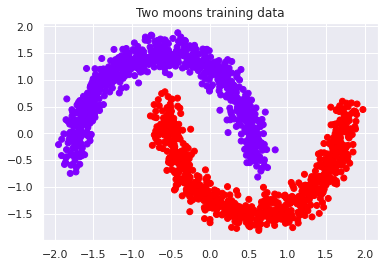

i= 0  kwargs= {'units': 4, 'kernel_initializer': 'normal', 'input_shape': [2], 'activation': 'relu'}
i= 1  kwargs= {'units': 4, 'kernel_initializer': 'normal', 'activation': 'relu'}
i= 2  kwargs= {'units': 1, 'kernel_initializer': 'normal', 'activation': 'sigmoid'}
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 4)                 12        
                                                                 
 dense_22 (Dense)            (None, 4)                 20        
                                                                 
 dense_23 (Dense)            (None, 1)                 5         
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
<ipython-input-59-ae8b1862c5cc>:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  weight_history = np.array(weight_history)


1/1 [==============================] - 0s 184ms/step


ValueError: ignored

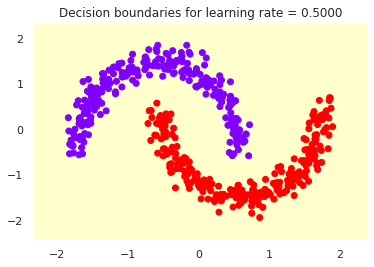

In [71]:
np.random.seed(random_seed)
(X_train, X_test, y_train, y_test) = make_training_data()
plot_training_data(X_train, y_train)

layer_sizes = [4, 4, 1]
epochs = [21, 21, 201] 
etas = [0.5, 0.05, 0.01] 
for (num_epochs, eta) in zip(epochs, etas):

    (model, layer_list, weight_history, history_list) = build_and_run_model(num_epochs, layer_sizes, eta)

    plot_decision_boundary(X_test, y_test, eta, lambda x: model.predict(x, batch_size=len(x)))

    show_history_graphs(history_list, eta)

    (weights_matrix, num_weights) = build_weights_matrix(weight_history, num_epochs)
    num_weights_to_graph = num_weights
    graph_changed_weights(weights_matrix, num_weights, num_weights_to_graph, eta)